# Intro
The purpose of this notebook is to compare the performance of two models in the task of analyzing Pnemonia or Normal X-ray images. The first model will simulate the typical architecture of a CNN whereas the second model will be based on a pretrained CNN named ResNet-50. The metric I'll use to compare both models will be overall accuracy. Moreover, I'll take into account the number of epochs it takes both models to converge to an optimal solution as a way of showing that a pretrained CNN converges faster than a model trained from zero.

# Check notebook kernel
For this notebook I'll use a venv environment

In [2]:
import sys
sys.executable

'/home/lesgueva/Desktop/mbd/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/PRÁCTICA_IMÁGENES/env/bin/python'

# Libraries

In [3]:
# Import all the libraries
import numpy as np 
import pandas as pd  
import os
import shutil
from PIL import Image, ImageOps  
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Concatenate, Flatten, MaxPooling2D, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
from keras.callbacks import CSVLogger
from keras.models import load_model


In [4]:
! pwd

/home/lesgueva/Desktop/mbd/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/PRÁCTICA_IMÁGENES


# Exploratory Data Analysis and Preprocessing

In [5]:
# import data
df = pd.read_csv('data/Chest_xray_Corona_Metadata.csv',index_col=0)
df.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [6]:
df.shape

(5910, 5)

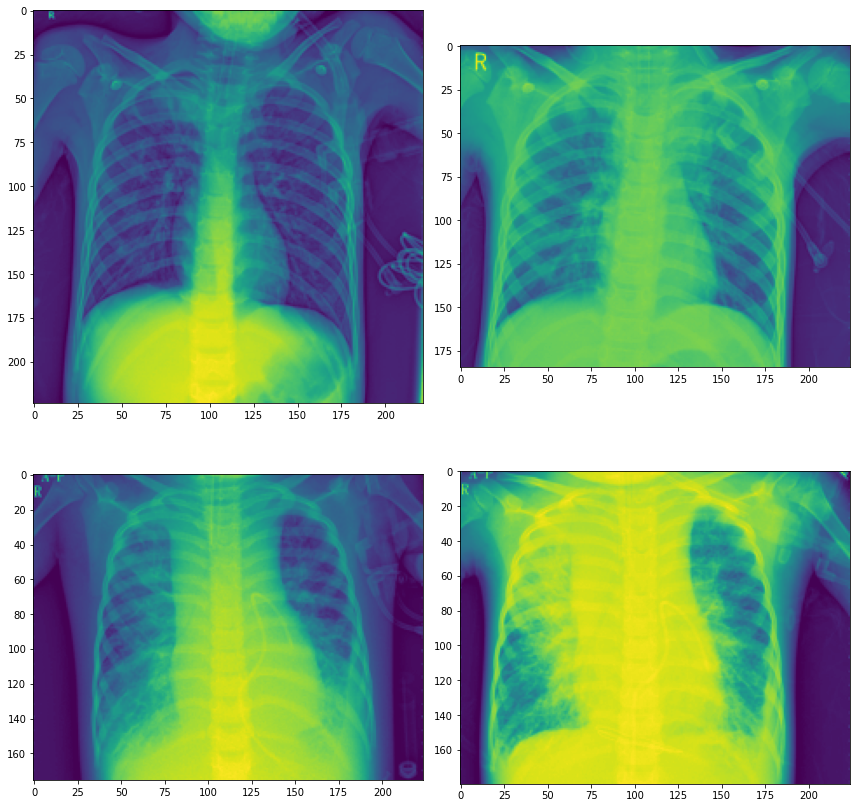

In [7]:
# Visualizing the Pneumonia affected Xrays
plt.figure(figsize=(12,12))

for index, fn in enumerate(df.loc[df['Label']=="Pnemonia"]['X_ray_image_name'].values[:4]):
    path = './data/images/' + str(fn)
    image = Image.open(path)
    image = ImageOps.grayscale(image)
    image.thumbnail((224,224))
    plt.subplot(2,2,index+1)
    plt.imshow(image)

plt.tight_layout()

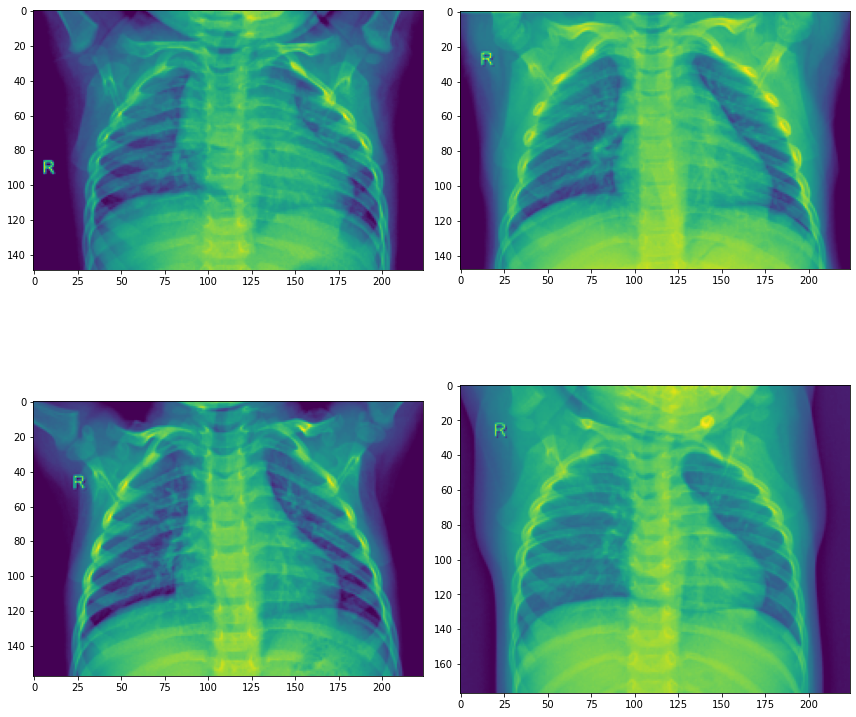

In [8]:
# Visualizing the Normal Xrays
plt.figure(figsize=(12,12))

for index, fn in enumerate(df.loc[df['Label']=="Normal"]['X_ray_image_name'].values[:4]):
    path = './data/images/' + str(fn)
    image = Image.open(path)
    image = ImageOps.grayscale(image)
    image.thumbnail((224,224))
    plt.subplot(2,2,index+1)
    plt.imshow(image)

plt.tight_layout()

In [9]:
# check the percentage of missing values
df.isnull().sum()/len(df)

X_ray_image_name          0.000000
Label                     0.000000
Dataset_type              0.000000
Label_2_Virus_category    0.988325
Label_1_Virus_category    0.266667
dtype: float64

In [10]:
# drop columns 'Label_2_Virus_category' and 'Label_1_Virus_category' as there are missing values and we are interested only in column 'Label' which tell us whether the person has Pnemonia or not. Moreover, 'Dataset_type' will also be deleted as we would like to set the train_test_split percentage.

df = df.drop(columns=['Dataset_type','Label_2_Virus_category','Label_1_Virus_category'])
df.head()

,X_ray_image_name,Label
0,IM-0128-0001.jpeg,Normal
1,IM-0127-0001.jpeg,Normal
2,IM-0125-0001.jpeg,Normal
3,IM-0122-0001.jpeg,Normal
4,IM-0119-0001.jpeg,Normal


In [11]:
# check if the data is imbalanced
df['Label'].value_counts() / len(df)

Pnemonia    0.733333
Normal      0.266667
Name: Label, dtype: float64

In [12]:
# apply undersampling because the data is imbalanced
df['Label'] = df['Label'].replace({'Pnemonia':1,'Normal':0})

Normal_filt = (df['Label']==0)
Normal_df = df.loc[Normal_filt]
print(f"Number of images corresponding to 'Normal' after Undersampling : {len(Normal_df)}")

Pnemonia_filt = (df['Label']==1)
Pnemonia_df = df.loc[Pnemonia_filt].sample(n=len(Normal_df),replace=False,random_state=2021)
print(f"Number of images corresponding to 'Pnemonia' after Undersampling : {len(Pnemonia_df)}")

assert len(Normal_df)==len(Pnemonia_df)

df_undersampled = pd.concat([Normal_df,Pnemonia_df], ignore_index=True).sample(frac=1).reset_index(drop=True)
print(f"df_undersampled shape is {df_undersampled.shape}\n")
df_undersampled.head(10)

Number of images corresponding to 'Normal' after Undersampling : 1576
Number of images corresponding to 'Pnemonia' after Undersampling : 1576
df_undersampled shape is (3152, 2)



,X_ray_image_name,Label
0,NORMAL2-IM-0465-0001.jpeg,0
1,person1499_bacteria_3915.jpeg,1
2,person100_bacteria_475.jpeg,1
3,NORMAL2-IM-0485-0001.jpeg,0
4,person277_bacteria_1306.jpeg,1
5,NORMAL2-IM-0736-0001.jpeg,0
6,NORMAL2-IM-0346-0001.jpeg,0
7,person402_bacteria_1813.jpeg,1
8,NORMAL2-IM-0553-0001.jpeg,0
9,NORMAL2-IM-0989-0001.jpeg,0


In [13]:
def train_val_test_split(df,ratio_train_test,ratio_train_val):
    """
    Split the data into train, validation and test sets given ratio_train_test and ratio_train_val.

    """

    # Split the data into train and test 
    train_df = df[:int(ratio_train_test*len(df))]
    test_df = df[int(ratio_train_test*len(df)):]

    # Split the data into train and validation
    val_df = train_df[int(ratio_train_val*len(train_df)):]
    train_df = train_df[:int(ratio_train_val*len(train_df))]

    print(f'\nnumber of samples in train_df: {len(train_df)}')
    print(f'number of samples in val_df: {len(val_df)}')
    print(f'number of samples in test_df: {len(test_df)}')

    assert len(df)==len(train_df)+len(test_df)+len(val_df)

    return train_df,val_df,test_df

In [14]:
train_df, val_df, test_df = train_val_test_split(df=df_undersampled, ratio_train_test=0.8, ratio_train_val=0.8)


number of samples in train_df: 2016
number of samples in val_df: 505
number of samples in test_df: 631


<AxesSubplot:>

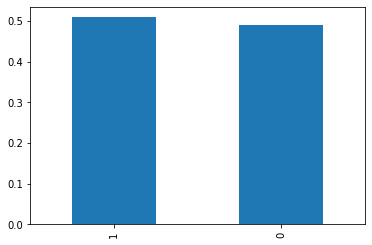

In [15]:
# check if the train_df is imbalanced
train_df['Label'].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot:>

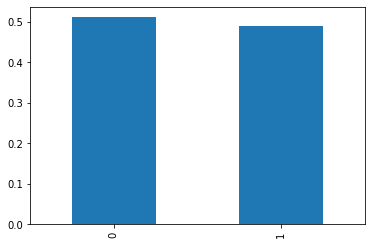

In [16]:
# check if the val_df is imbalanced
val_df['Label'].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot:>

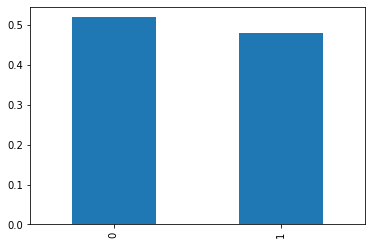

In [17]:
# check if the test_df is imbalanced
test_df['Label'].value_counts(normalize=True).plot(kind="bar")

#### The distribution of train, val and test sets are almost identical (50%Normal/50%Pnemonia) so we can go forward to the next step.

# Create a function to put the images into their respective folder

The purpose of this function is to put the images into train, validation and test folders according to ratio_train_test and ratio_train_val (previous step)

In [18]:
def images_to_folders(images_folder_path, train_df, validation_df, test_df, output_folder_path):

    """
    Move images from images_folder_path to a folder with train, validation and test subfolders (according to train_df, validation_df and test_df)

    Params
    ------

        images_folder_path : str
            path to the folder which contains all the images

        train_df : pandas.Dataframe
            dataframe which contains filename and label of the images that will be used for training the cnn

        validation_df : pandas.Dataframe
            dataframe which contains filename and label of the images that will be used for validating the performance of the cnn during the training

        test_df : pandas.Dataframe
            dataframe which contains filename and label of the images that will be used for testing the performance of the cnn after the training step
        
        output_folder_path : str
            path to the folder which will contain the images classified into 3 subfolders, train, validation and test

    """
    

    # Remove and Create new folders to store the images that will be moved
    if os.path.exists(output_folder_path):
        print("there is already an output folder with the same name so the data will be overwritten")
        shutil.rmtree(output_folder_path)
        os.makedirs(os.path.join(output_folder_path,"train/Pneumonia"))
        os.makedirs(os.path.join(output_folder_path,"train/Normal"))
        os.makedirs(os.path.join(output_folder_path,"val/Pneumonia"))
        os.makedirs(os.path.join(output_folder_path,"val/Normal"))
        os.makedirs(os.path.join(output_folder_path,"test/Pneumonia"))
        os.makedirs(os.path.join(output_folder_path,"test/Normal"))        
        print("empty output folder created")
    else:
        os.makedirs(os.path.join(output_folder_path,"train/Pneumonia"))
        os.makedirs(os.path.join(output_folder_path,"train/Normal"))
        os.makedirs(os.path.join(output_folder_path,"val/Pneumonia"))
        os.makedirs(os.path.join(output_folder_path,"val/Normal"))
        os.makedirs(os.path.join(output_folder_path,"test/Pneumonia"))
        os.makedirs(os.path.join(output_folder_path,"test/Normal"))
        print("empty output folder created")
    

    # Move images from images_folder_path to train and validation subfolders located into output_folder_path
    filenames_train_pneumonia = train_df[train_df.Label==1]['X_ray_image_name'].values
    filenames_train_normal = train_df[train_df.Label==0]['X_ray_image_name'].values

    filenames_val_pneumonia = validation_df[validation_df.Label==1]['X_ray_image_name'].values
    filenames_val_normal = validation_df[validation_df.Label==0]['X_ray_image_name'].values

    filenames_test_pneumonia = test_df[test_df.Label==1]['X_ray_image_name'].values
    filenames_test_normal = test_df[test_df.Label==0]['X_ray_image_name'].values


    print("\nMoving the images...")

    # move train images
    for image_filename in filenames_train_pneumonia:
        shutil.copy( os.path.join(images_folder_path, str(image_filename)) , os.path.join(output_folder_path,"train/Pneumonia") )
    print('\n{} images have been moved to {}'.format(len(filenames_train_pneumonia),os.path.join(output_folder_path,"train/Pneumonia")))
        
    for image_filename in filenames_train_normal:
        shutil.copy( os.path.join(images_folder_path, str(image_filename)) , os.path.join(output_folder_path,"train/Normal") )
    print('{} images have been moved to {}'.format(len(filenames_train_normal),os.path.join(output_folder_path,"train/Normal")))

    # move validation images
    for image_filename in filenames_val_pneumonia:
        shutil.copy( os.path.join(images_folder_path, str(image_filename)) , os.path.join(output_folder_path,"val/Pneumonia") )
    print('{} images have been moved to {}'.format(len(filenames_val_pneumonia),os.path.join(output_folder_path,"val/Pneumonia")))

    for image_filename in filenames_val_normal:
        shutil.copy( os.path.join(images_folder_path, str(image_filename)) , os.path.join(output_folder_path,"val/Normal") )
    print('{} images have been moved to {}'.format(len(filenames_val_normal),os.path.join(output_folder_path,"val/Normal")))

    # move test images
    for image_filename in filenames_test_pneumonia:
        shutil.copy( os.path.join(images_folder_path, str(image_filename)) , os.path.join(output_folder_path,"test/Pneumonia") )
    print('{} images have been moved to {}'.format(len(filenames_test_pneumonia),os.path.join(output_folder_path,"test/Pneumonia")))

    for image_filename in filenames_test_normal:
        shutil.copy( os.path.join(images_folder_path, str(image_filename)) , os.path.join(output_folder_path,"test/Normal") )
    print('{} images have been moved to {}'.format(len(filenames_test_normal),os.path.join(output_folder_path,"test/Normal")))


In [19]:
images_folder_path="./data/images"
output_folder_path="./folders_with_images_classified"

images_to_folders(
    images_folder_path=images_folder_path,
    train_df=train_df,
    validation_df=val_df,
    test_df=test_df,
    output_folder_path=output_folder_path
)

there is already an output folder with the same name so the data will be overwritten
empty output folder created

Moving the images...

1026 images have been moved to ./folders_with_images_classified/train/Pneumonia
990 images have been moved to ./folders_with_images_classified/train/Normal
247 images have been moved to ./folders_with_images_classified/val/Pneumonia
258 images have been moved to ./folders_with_images_classified/val/Normal
303 images have been moved to ./folders_with_images_classified/test/Pneumonia
328 images have been moved to ./folders_with_images_classified/test/Normal


# Models

In this section, two models will be trained and evaluated on the data

## 1. Own Model
This model will be created from zero, this means that the typical cnn architecture will be simulated ({Conv2D+MaxPooling2D} x Ntimes + Flatten layer + Dense neural network).
The number of filters will increase and the output shape decrease (width and height of the image) as we go through the {Conv2D+MaxPooling2D} x Ntimes block. Then the flatten layer will flatten the output of the {Conv2D+MaxPooling2D} x Ntimes block so that we have a 1D vector with all the features of the image extracted. After that, a densely connected neural network will classify the image according to the 1D vector. The {Conv2D+MaxPooling2D} x Ntimes block is responsible for extracting the relevant features of the image and once this step has finished the densely connected neural network is responsible for classifying correctly the image according to the features extracted previously.

In [20]:
# Hyperparams
IMAGE_WIDTH, IMAGE_HEIGHT = 200, 200
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3) # RGB images have 3 channels
EPOCHS = 30
BATCH_SIZE = 64

In [21]:
# Create the architecture of the CNN (filters of 3x3 and increase the number of filters by a factor of 2, MaxPooling of 2x2 to reduce the width and height of the image by a factor of 2, stride of 1, padding 'same' so that the width and height of the image is the same after applying the filter, 'relu' activation, flatten layer, densely connected neural network with dropout layers to avoid overfitting and final activation 'sigmoid' as we want a binary classifier)

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('sigmoid'))


In [22]:
# write the architecture of the model into a txt file
with open("own_model_summary.txt","w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))
# print the architecture of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 128)       7

In [23]:
# compile the model 
model.compile(
    loss='binary_crossentropy', # binary classifier
    optimizer=Adam(lr=0.0001), # adam provides a good and fast convergence
    metrics=['accuracy'] # metrics to show the performance of the neural network
    )

In [24]:
training_data_generator = ImageDataGenerator( # apply data augmentation by rescaling the pixels value, flip, zoom and shear images
                            rescale=1./255,
                            shear_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
                            
validation_data_generator = ImageDataGenerator(rescale=1./255)

test_data_generator = ImageDataGenerator(rescale=1./255)

training_generator = training_data_generator.flow_from_directory(
    os.path.join(output_folder_path,"train"),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")

validation_generator = validation_data_generator.flow_from_directory(
    os.path.join(output_folder_path,"val"),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")

test_generator = test_data_generator.flow_from_directory(
    os.path.join(output_folder_path,"test"),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)

Found 2016 images belonging to 2 classes.
Found 505 images belonging to 2 classes.
Found 631 images belonging to 2 classes.


In [25]:
# EarlyStopping will stop training as soon as the monitor metric stops decreasing for a number of patience epochs. After that it will restore the best_weights according to the best result in monitor metric (I'll choose val_loss)
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=5,
                    verbose=0,
                    mode="min",
                    restore_best_weights=True
                )

In [26]:
# Training
history = model.fit(
                training_generator,
                steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=validation_generator,
                validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
                callbacks=[CSVLogger("own_model_training_logs.csv", append=False, separator=","), early_stopping],
                verbose=1
          )
 

Epoch 1/30
31/31 [==============================] - 535s 17s/step - loss: 0.6911 - accuracy: 0.5217 - val_loss: 0.6560 - val_accuracy: 0.7009
Epoch 2/30
31/31 [==============================] - 547s 18s/step - loss: 0.6006 - accuracy: 0.7502 - val_loss: 0.3684 - val_accuracy: 0.8527
Epoch 3/30
31/31 [==============================] - 559s 18s/step - loss: 0.3808 - accuracy: 0.8525 - val_loss: 0.3483 - val_accuracy: 0.8460
Epoch 4/30
31/31 [==============================] - 546s 18s/step - loss: 0.3081 - accuracy: 0.8743 - val_loss: 0.2293 - val_accuracy: 0.8929
Epoch 5/30
31/31 [==============================] - 489s 16s/step - loss: 0.2648 - accuracy: 0.9079 - val_loss: 0.2298 - val_accuracy: 0.9040
Epoch 6/30
31/31 [==============================] - 431s 14s/step - loss: 0.2364 - accuracy: 0.9137 - val_loss: 0.1782 - val_accuracy: 0.9263
Epoch 7/30
31/31 [==============================] - 428s 14s/step - loss: 0.2213 - accuracy: 0.9198 - val_loss: 0.1797 - val_accuracy: 0.9420
Epoch 

In [27]:
# save the model trained
model.save('own_model.h5')

In [28]:
def plot_training_logs_from_csv(training_logs_path, figsize=(15,5)):
    """
    Plot the loss and accuracy obtained during the training. With this function you don't need to train the cnn each time you restart the kernel and want to see the loss/accuracy plots.

    Params
    ------

        training_logs_path : str
            path to the csv which contains the loss and accuracy obtained during the training
    
    """
    # read the data
    training_logs_df = pd.read_csv(training_logs_path)

    # create the subplots
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=figsize)

    # set fontsizes
    titles_fontsize = 20
    xlabel_fontsize = 15
    ylabel_fontsize = 15

    # accuracy plots
    ax1.plot(training_logs_df['epoch'].values, training_logs_df['accuracy'].values, label="train")
    ax1.plot(training_logs_df['epoch'].values, training_logs_df['val_accuracy'].values, label="val")
    ax1.set_title('model accuracy',fontsize=titles_fontsize)
    ax1.set_ylabel('accuracy',fontsize=ylabel_fontsize)
    ax1.set_xlabel('epoch',fontsize=xlabel_fontsize)
    ax1.legend()

    # loss plots
    ax2.plot(training_logs_df['epoch'].values, training_logs_df['loss'].values, label="train")
    ax2.plot(training_logs_df['epoch'].values, training_logs_df['val_loss'].values, label="val")
    ax2.set_title('model loss',fontsize=titles_fontsize)
    ax2.set_ylabel('loss',fontsize=ylabel_fontsize)
    ax2.set_xlabel('epoch',fontsize=xlabel_fontsize)
    ax2.legend()

    plt.show()

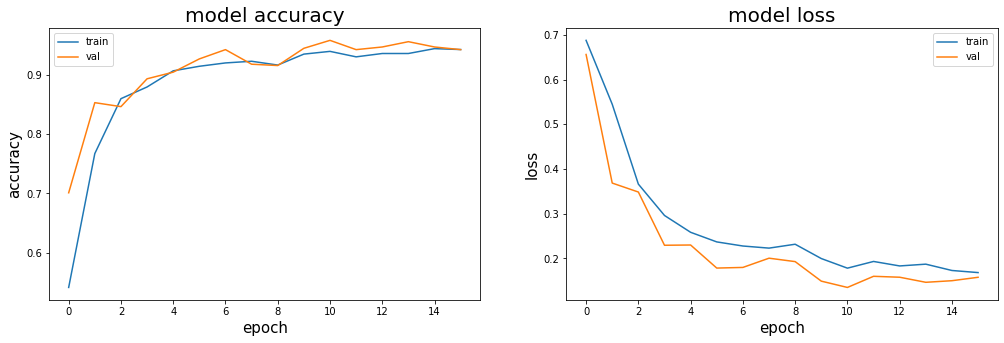

In [29]:
plot_training_logs_from_csv("./own_model_training_logs.csv",figsize=(17,5))

In [30]:
#restore model 
model = load_model('./own_model.h5')

In [31]:
scores = model.evaluate(test_generator) 

631/631 [==============================] - 42s 66ms/step - loss: 0.1420 - accuracy: 0.9398


In [32]:
print("own_model overall accuracy on test set = ", round(scores[1],4))

own_model overall accuracy on test set =  0.9398


## 2. Transfer Learning Model

In this section, I'll apply transfer learning to analyze the images (the pretrained CNN will be 'ResNet50')

In [33]:
# Model configuration
img_width, img_height, img_num_channels = 224,224,3
input_shape = (img_width, img_height, img_num_channels)
epochs = 30
batch_size = 64

In [34]:
# Initialize a base pre-trained CNN without the classification layer
base_model = getattr(tf.keras.applications, 'ResNet50')(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze convolutional layers (starting from the end of the convolutional layers pack)
unfreezed_convolutional_layers = 0

if unfreezed_convolutional_layers == 0:
    freezed_layers = base_model.layers
elif unfreezed_convolutional_layers > 0:
    freezed_layers = base_model.layers[:-unfreezed_convolutional_layers]

for layer in freezed_layers:
    layer.trainable = False

In [35]:
# Create the architecture of the model
model = tf.keras.models.Sequential()

# Add the convolutional base model
model.add(base_model)

# Add new layers
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [36]:
# write the architecture of the model into a txt file
with open("transfer_learning_model_summary.txt","w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))
# print the architecture of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

In [37]:
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy']
    )

In [38]:
# Configure loading and pre-processing/data augmentation functions
print('\n\nReading training and validation data...')

training_datagen = tf.keras.preprocessing.image.ImageDataGenerator( # apply data augmentation to training data
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,  # Randomly flip half of the images horizontally
    fill_mode='nearest'  # Strategy used for filling in new pixels that appear after transforming images
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

training_generator = training_datagen.flow_from_directory(
    os.path.join(output_folder_path,"train"),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(output_folder_path,"val"),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(output_folder_path,"test"),
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode="binary",
    shuffle=False
)




Reading training and validation data...
Found 2016 images belonging to 2 classes.
Found 505 images belonging to 2 classes.
Found 631 images belonging to 2 classes.


In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=5,
                    verbose=0,
                    mode="min",
                    restore_best_weights=True
                )

In [40]:
# training
history = model.fit(
    training_generator,
    epochs=epochs,
    steps_per_epoch=len(training_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[CSVLogger("transfer_learning_model_training_logs.csv", append=False, separator=","), early_stopping]
)

Epoch 1/30
32/32 [==============================] - 285s 9s/step - loss: 0.7000 - accuracy: 0.7142 - val_loss: 0.3058 - val_accuracy: 0.8713
Epoch 2/30
32/32 [==============================] - 281s 9s/step - loss: 0.3718 - accuracy: 0.8676 - val_loss: 0.1936 - val_accuracy: 0.9267
Epoch 3/30
32/32 [==============================] - 282s 9s/step - loss: 0.2747 - accuracy: 0.8882 - val_loss: 0.2126 - val_accuracy: 0.9109
Epoch 4/30
32/32 [==============================] - 281s 9s/step - loss: 0.2763 - accuracy: 0.8970 - val_loss: 0.2489 - val_accuracy: 0.9168
Epoch 5/30
32/32 [==============================] - 282s 9s/step - loss: 0.2185 - accuracy: 0.9111 - val_loss: 0.1519 - val_accuracy: 0.9485
Epoch 6/30
32/32 [==============================] - 282s 9s/step - loss: 0.2346 - accuracy: 0.9176 - val_loss: 0.1469 - val_accuracy: 0.9465
Epoch 7/30
32/32 [==============================] - 282s 9s/step - loss: 0.1662 - accuracy: 0.9448 - val_loss: 0.1561 - val_accuracy: 0.9485
Epoch 8/30
32

In [41]:
# save the model
model.save("transfer_learning_model.h5")

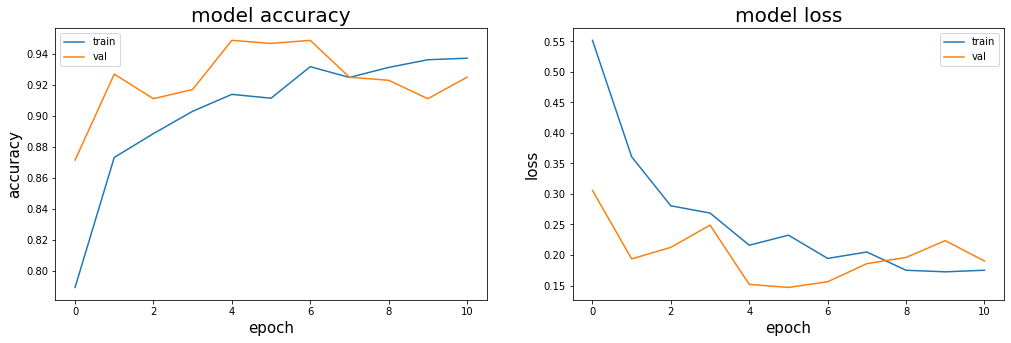

In [42]:
# plot loss and metrics during training
plot_training_logs_from_csv("./transfer_learning_model_training_logs.csv",figsize=(17,5))

In [43]:
# restore model
model = load_model('./transfer_learning_model.h5')

In [44]:
# evaluate the model on test set 
scores = model.evaluate(test_generator) 

631/631 [==============================] - 83s 131ms/step - loss: 0.1256 - accuracy: 0.9540


In [45]:
print("model based on Resnet-50 overall accuracy on test set = ", round(scores[1],4))

model based on Resnet-50 overall accuracy on test set =  0.954
